In [1]:
#介绍CART(classification and regression tree)分类回归树

#先介绍，决策树对于连续性数值的回归问题————回归树
#1，切分数据：二元切分法，x>a和x<=a,其中的a属于某个特征xi的所有取值集合
#2,选择特征：选择使得，切分数据的总均方差最小
#3,预测：使用切分数据集的平均值，代表预测值

#先导入数据
import numpy as np
def loadDataSet(fileName):      
    dataMat = []                #assume last column is target value
    fr = open(fileName)
    for line in fr.readlines():
        curLine = line.strip().split('\t')
        floatLine = map(float,curLine) #map all elements to float()
        dataMat.append(floatLine) #这里把最后一列作为目标变量，y
    return np.mat(dataMat)

myData= loadDataSet('regressionTree/ex00.txt')
print myData.shape





(200L, 2L)


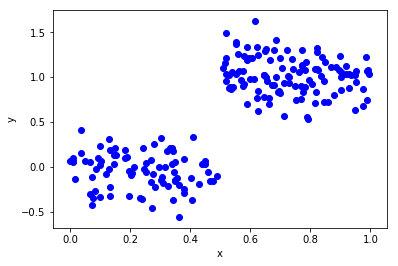

In [2]:
#可视化一下ex00.txt的数据
import matplotlib.pyplot as plt
plt.scatter(myData[:,0].A,myData[:,1].A,color="blue") #np.matrix.A--->matrix转化为array
plt.xlabel("x")
plt.ylabel("y")
plt.show()


In [3]:
#二元切分法,x>a和x<=a,其中的a属于某个特征xi的所有取值集合
#notice:切分的特征并没有删除，这与前面ID3算法的决策树分类中，切分数据不同!!!

def binSplitDataSet(dataSet, feature, value):
    mat0 = dataSet[np.nonzero(dataSet[:,feature] > value)[0],:]
    mat1 = dataSet[np.nonzero(dataSet[:,feature] <= value)[0],:]
    return mat0,mat1
#测试一下
mat0,mat1 = binSplitDataSet(myData,0,0.5)
print mat0.shape,mat1.shape



(116L, 2L) (84L, 2L)


In [4]:
#树回归的叶子节点————数据集合中y的均值
def regLeaf(dataSet):
    return np.mean(dataSet[:,-1])

#用y的总均方差代表连续型数据的混乱度
def regErr(dataSet):
    return np.var(dataSet[:,-1]) * np.shape(dataSet)[0] #总均方差=均方差*num

#选择合适的特征划分:返回最好的特征bestIndex,和对应的值bestValue

def chooseBestSplit(dataSet, leafType=regLeaf, errType=regErr, ops=(1,4)):
    tolS = ops[0] #均方差变化的最小幅度，用于预剪枝
    tolN = ops[1] #划分的数据集的最小size
   
    if len(set(dataSet[:,-1].T.tolist()[0])) == 1: #exit condition 1:
        # 如果所有的y的值都相等，这里用set去重,直接返回叶子节点，不做划分
        return None, leafType(dataSet) #直接返回
    m,n = np.shape(dataSet) #数据集合大小
    #the choice of the best feature is driven by Reduction in RSS error from mean
    S = errType(dataSet) #原来数据集合的总均方差
    bestS = np.inf
    bestIndex = 0
    bestValue = 0
    for featureIndex in range(n-1): #遍历每一个特征：因为下标-1是y的值，不是特征
        for splitVal in set(dataSet[:,featureIndex].A.ravel()): #遍历当前特征的每一个取值
            mat0, mat1 = binSplitDataSet(dataSet, featureIndex, splitVal)
            if (np.shape(mat0)[0] < tolN) or (np.shape(mat1)[0] < tolN): 
                #如果划分之后的数据集合size太小了，直接跳过，不划分
                continue
            newS = errType(mat0) + errType(mat1) #划分之后的两个小数据集合的总均方差
            if newS < bestS:  #选出最优值
                bestIndex = featureIndex
                bestValue = splitVal
                bestS = newS
    #if the decrease (S-bestS) is less than a threshold,don't do the split
    if (S - bestS) < tolS:
        #误差变化的幅度太小，直接返回叶子节点，不做划分
        return None, leafType(dataSet) #exit condition 2 #退出条件2
    mat0, mat1 = binSplitDataSet(dataSet, bestIndex, bestValue) #最优的划分子集合
    if (np.shape(mat0)[0] < tolN) or (np.shape(mat1)[0] < tolN):  #exit condition 3
        #划分的子集合太小,直接返回叶子节点，不做划分
        return None, leafType(dataSet)
    return bestIndex,bestValue#returns the best feature to split on
                              #and the value used for that split


In [5]:
#用一个全局变量，来保存最优的划分数据
bestFeatures=[]
bestValues=[]


#递归创建回归树
def createTree(dataSet, leafType=regLeaf, errType=regErr, ops=(1,4)):
    #assume dataSet is NumPy Mat so we can array filtering
    feature, val = chooseBestSplit(dataSet, leafType, errType, ops)#choose the best split
    if feature == None: #如果返回的是没有划分，和叶子节点的值
        return val #if the splitting hit a stop condition return val
    retTree = {}
    retTree['spInd'] = feature
    retTree['spVal'] = val
    
    bestFeatures.append(feature)#保存下来
    bestValues.append(val)
    
    lSet, rSet = binSplitDataSet(dataSet, feature, val) #分成左右两个子树
    retTree['left'] = createTree(lSet, leafType, errType, ops)
    retTree['right'] = createTree(rSet, leafType, errType, ops)
    
    return retTree  

#测试一下
myData= loadDataSet('regressionTree/ex00.txt')
myTree = createTree(myData)
print myTree


{'spInd': 0, 'spVal': 0.48813000000000001, 'right': -0.044650285714285719, 'left': 1.0180967672413792}


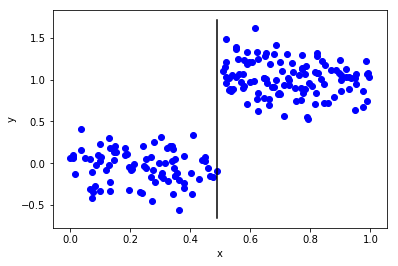

In [6]:
#可视化一下ex00.txt数据集的划分界限

import matplotlib.pyplot as plt
plt.scatter(myData[:,0].A,myData[:,1].A,color="blue")

y = myData[:,-1].A
y_min = np.min(y) - 0.1
y_max = np.max(y) + 0.1
y_val = np.arange(y_min,y_max,0.01)
for i in xrange(len(bestValues)):
    plt.plot([bestValues[i]]*y_val.shape[0],y_val,color="black") #画出那条分界线
plt.xlabel("x")
plt.ylabel("y")
plt.show()


In [7]:
#测试一下ex0.txt数据集


bestFeatures = [] #先清空一下list,注意python2没有clear（）
bestValues = []

myData= loadDataSet('regressionTree/ex0.txt')
print myData.shape
myTree = createTree(myData)
print myTree


(200L, 3L)
{'spInd': 1, 'spVal': 0.39434999999999998, 'right': {'spInd': 1, 'spVal': 0.19783400000000001, 'right': -0.023838155555555553, 'left': 1.0289583666666666}, 'left': {'spInd': 1, 'spVal': 0.58200200000000002, 'right': 1.980035071428571, 'left': {'spInd': 1, 'spVal': 0.79758300000000004, 'right': 2.9836209534883724, 'left': 3.9871631999999999}}}


[0.39434999999999998, 0.58200200000000002, 0.79758300000000004, 0.19783400000000001]


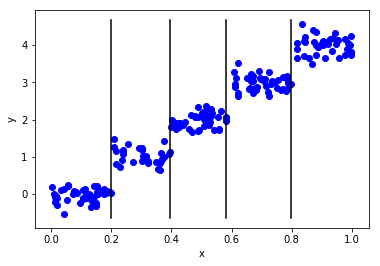

In [8]:
#可视化一下ex0.txt数据集的划分界限
print bestValues

import matplotlib.pyplot as plt
plt.scatter(myData[:,1].A,myData[:,-1].A,color="blue")

y = myData[:,-1].A
y_min = np.min(y) - 0.1
y_max = np.max(y) + 0.1
y_val = np.arange(y_min,y_max,0.01)
for i in xrange(len(bestValues)):
    plt.plot([bestValues[i]]*y_val.shape[0],y_val,color="black")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


In [9]:
#接下来，构建模型树————即，叶子节点存放的不是数据集合的均值，而是数据集合的线性方程
#最佳划分的判断：选择线性方程拟合的误差最小的划分方法

def linearSolve(dataSet):   #在线性回归中，用到的求解最优w的公式
    m,n = np.shape(dataSet)
    X = np.mat(np.ones((m,n)))
    Y = np.mat(np.ones((m,1)))#create a copy of data with 1 in 0th postion
    X[:,1:n] = dataSet[:,0:n-1] #注意，这里，只改变了1-(n-1)维度的数据，因为x0=1
    Y = dataSet[:,-1]#and strip out Y
    xTx = X.T*X
    if np.linalg.det(xTx) == 0.0:
        raise NameError('This matrix is singular, cannot do inverse,\n\
        try increasing the second value of ops')
    ws = xTx.I * (X.T * Y)
    return ws,X,Y

def modelLeaf(dataSet):#模型树的叶子节点返回的是：线性方程的系数
    ws,X,Y = linearSolve(dataSet)
    return ws

def modelErr(dataSet): #返回总的误差，用于判断划分的好坏
    ws,X,Y = linearSolve(dataSet)
    yHat = X * ws
    return np.sum(np.power(Y - yHat,2))




(200L, 2L)


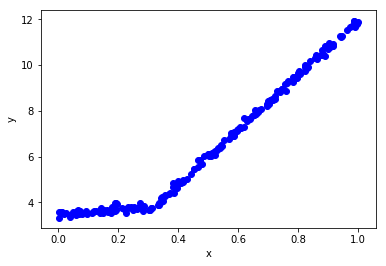

In [11]:
#先导入数据集合，并且可视化一下

myData2 = loadDataSet('regressionTree/exp2.txt')
print myData2.shape
plt.scatter(myData2[:,0].A,myData2[:,-1].A,color="blue")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [12]:
#现在利用上面的数据，生成模型树

bestFeatures = [] #先清空一下list,注意python2没有clear（）
bestValues = []
myModelTree = createTree(myData2,leafType=modelLeaf,errType=modelErr,ops=(1,10))
print myModelTree

print bestValues
print bestFeatures


{'spInd': 0, 'spVal': 0.28547699999999998, 'right': matrix([[ 3.46877936],
        [ 1.18521743]]), 'left': matrix([[  1.69855694e-03],
        [  1.19647739e+01]])}
[0.28547699999999998]
[0]


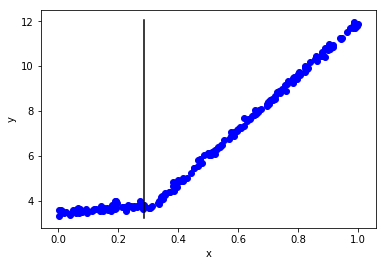

In [13]:
#可视化一下exp.txt数据集的划分界限


plt.scatter(myData2[:,0].A,myData2[:,1].A,color="blue")

y = myData2[:,-1].A
y_min = np.min(y) - 0.1
y_max = np.max(y) + 0.1
y_val = np.arange(y_min,y_max,0.01)
for i in xrange(len(bestValues)):
    plt.plot([bestValues[i]]*y_val.shape[0],y_val,color="black") #画出那条分界线
plt.xlabel("x")
plt.ylabel("y")
plt.show()


In [14]:
#最后看看怎么进行预测

#判断是不是树，也就是字典
def isTree(obj):
    return (type(obj).__name__=='dict')

#回归树，直接返回叶子节点的值：小数据集合的均值
def regTreeEval(leaf, inData):
    return float(leaf)

#模型树，返回线性方程的值
def modelTreeEval(leaf, inData):
    n = np.shape(inData)[1]
    X = np.mat(np.ones((1,n+1))) #x0=1
    X[:,1:n+1] = inData
    return float(X*leaf)

#树的递归预测
def treeForeCast(tree, inData, modelEval=regTreeEval):
    if not isTree(tree): #如果不是树，叶子节点，则返回预测值
        return modelEval(tree, inData)
    if inData.A.ravel()[tree['spInd']] > tree['spVal']: #大于特征值，则是左子树
        if isTree(tree['left']): #如果是树，继续递归
            return treeForeCast(tree['left'], inData, modelEval) #递归
        else: #如果是叶子节点，直接返回预测值
            return modelEval(tree['left'], inData)
    else: #小于等于则是右子树
        if isTree(tree['right']): 
            return treeForeCast(tree['right'], inData, modelEval)
        else: 
            return modelEval(tree['right'], inData)

#利用生成的树，进行预测
def createForeCast(tree, testData, modelEval=regTreeEval):
    m=len(testData)
    yHat = np.mat(np.zeros((m,1)))
    for i in range(m):
        yHat[i,0] = treeForeCast(tree, np.mat(testData[i]), modelEval) #递归预测
    return yHat


(200L, 1L)


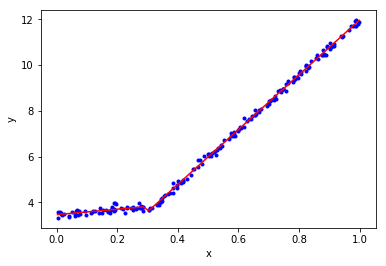

In [15]:
yhat = createForeCast(myModelTree,myData2[:,0:-1],modelEval=modelTreeEval)
print yhat.shape

srtIndex = myData2.A[:,0].argsort(0)#排个序

plt.scatter(myData2.A[:,0],myData2.A[:,1],color="blue",marker=".")
plt.plot(myData2[:,0].A[srtIndex],yhat.A[srtIndex],color="red",linestyle = "-")
plt.xlabel("x")
plt.ylabel("y")
plt.show()
